Fitting 5 folds for each of 108 candidates, totalling 540 fits
Validation Accuracy: 0.7816091954022989
Test Accuracy: 0.7471264367816092
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75        44
           1       0.74      0.74      0.74        43

    accuracy                           0.75        87
   macro avg       0.75      0.75      0.75        87
weighted avg       0.75      0.75      0.75        87

Top investment candidates:
                             company   close  intrinsic_value    value_diff
2570               Intel Corporation   34.45     2.087500e+08  2.087500e+08
1081    Bristol-Myers Squibb Company   59.17     1.632500e+08  1.632499e+08
2798               Johnson & Johnson   52.60     1.219500e+08  1.219499e+08
1231     Charter Communications Inc.  104.18     4.755000e+07  4.754990e+07
558                  Amazon.com Inc.   83.66     2.079500e+07  2.079492e+07
2494  Intercontinental Exchang

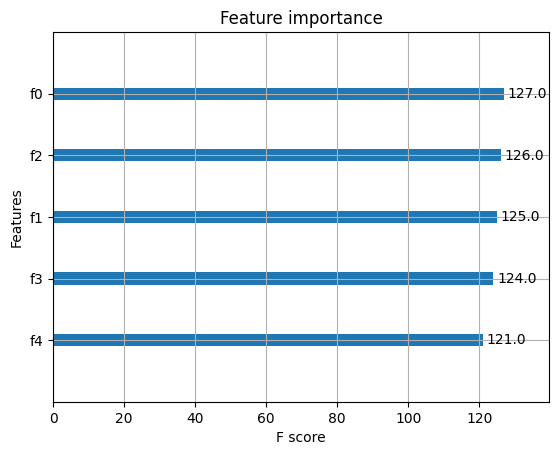

In [53]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import xgboost as xgb

# Load the dataset
data = pd.read_csv("final_merged_data.csv")


if 'company' not in data.columns or 'date' not in data.columns:
    raise KeyError("The dataset does not contain 'company' or 'date' columns. Please check your dataset.")


data['date'] = pd.to_datetime(data['date'])
data['quarter'] = data['date'].dt.to_period('Q')


companies = [
    'IBM', 'AAPL', 'GOOGL', 'MSFT', 'AMZN', 'FB', 'JPM', 'JNJ', 'BRK.B', 'V', 'PG', 'XOM', 'BAC', 'WFC', 'VZ', 'UNH',
    'T', 'DIS', 'CVX', 'KO', 'INTC', 'CSCO', 'CMCSA', 'PEP', 'HD', 'PFE', 'MRK', 'BA', 'ORCL', 'NFLX', 'NVDA',
    'PYPL', 'ADBE', 'CRM', 'ABBV', 'ABT', 'TSLA', 'MCD', 'COST', 'NKE', 'TMO', 'ACN', 'AMGN', 'AVGO', 'NEE',
    'UNP', 'LLY', 'TXN', 'QCOM', 'LIN', 'DHR', 'PM', 'C', 'LOW', 'CME', 'MDT', 'SBUX', 'UPS', 'GS', 'LMT',
    'BKNG', 'HON', 'NOW', 'AMT', 'MMM', 'AXP', 'RTX', 'AMD', 'DUK', 'BMY', 'BLK', 'GE', 'CVS', 'TGT', 'CHTR',
    'CAT', 'ISRG', 'INTU', 'FIS', 'MU', 'SCHW', 'USB', 'SYK', 'ANTM', 'DE', 'GD', 'ZTS', 'LRCX', 'EQIX',
    'SPGI', 'ITW', 'ICE', 'WM', 'SO', 'AON', 'TMUS', 'ADI'
]

selected_companies = np.random.choice(companies, size=10, replace=False)


data = data[data['company'].isin(selected_companies)]

selected_columns = [
   'nonInterestIncome', 'costOfRevenue', 'totalRevenue', 'netIncome', 'comprehensiveIncomeNetOfTax',
   'incomeBeforeTax', 'currentAccountsPayable', 'profitLoss', 'paymentsForRepurchaseOfCommonStock',
   'researchAndDevelopment'
]


missing_columns = [col for col in selected_columns if col not in data.columns]
if missing_columns:
    print(f"Missing columns: {missing_columns}")
    # Remove missing columns from the selected list
    selected_columns = [col for col in selected_columns if col in data.columns]


target_variable = 'close'
median_close = data[target_variable].median()
data['recommend'] = (data[target_variable] >= median_close).astype(int)


grouped_data = data.groupby(['company', 'quarter'])


X_list = []
y_list = []

for _, group in grouped_data:
    X_group = group[selected_columns]
    y_group = group['recommend']
    X_list.append(X_group)
    y_list.append(y_group)


X = pd.concat(X_list)
y = pd.concat(y_list)


scaler = StandardScaler()
X = scaler.fit_transform(X)


pca = PCA(n_components=0.95)  # 95% of the variance
X = pca.fit_transform(X)


X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)


xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Define parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}


tscv = TimeSeriesSplit(n_splits=5)


grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=tscv, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)


best_xgb_model = grid_search.best_estimator_


y_val_pred = best_xgb_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {val_accuracy}')


y_test_pred = best_xgb_model.predict(X_test)


accuracy = accuracy_score(y_test, y_test_pred)
classification_rep = classification_report(y_test, y_test_pred)

print(f'Test Accuracy: {accuracy}')
print(f'Classification Report:\n{classification_rep}')


symbol_to_name = {
    'IBM': 'International Business Machines Corporation',
    'AAPL': 'Apple Inc.',
    'GOOGL': 'Alphabet Inc.',
    'MSFT': 'Microsoft Corporation',
    'AMZN': 'Amazon.com Inc.',
    'FB': 'Meta Platforms Inc.',
    'JPM': 'JPMorgan Chase & Co.',
    'JNJ': 'Johnson & Johnson',
    'BRK.B': 'Berkshire Hathaway Inc.',
    'V': 'Visa Inc.',
    'PG': 'Procter & Gamble Company',
    'XOM': 'Exxon Mobil Corporation',
    'BAC': 'Bank of America Corporation',
    'WFC': 'Wells Fargo & Company',
    'VZ': 'Verizon Communications Inc.',
    'UNH': 'UnitedHealth Group Incorporated',
    'T': 'AT&T Inc.',
    'DIS': 'The Walt Disney Company',
    'CVX': 'Chevron Corporation',
    'KO': 'The Coca-Cola Company',
    'INTC': 'Intel Corporation',
    'CSCO': 'Cisco Systems Inc.',
    'CMCSA': 'Comcast Corporation',
    'PEP': 'PepsiCo Inc.',
    'HD': 'The Home Depot Inc.',
    'PFE': 'Pfizer Inc.',
    'MRK': 'Merck & Co. Inc.',
    'BA': 'The Boeing Company',
    'ORCL': 'Oracle Corporation',
    'NFLX': 'Netflix Inc.',
    'NVDA': 'NVIDIA Corporation',
    'PYPL': 'PayPal Holdings Inc.',
    'ADBE': 'Adobe Inc.',
    'CRM': 'salesforce.com Inc.',
    'ABBV': 'AbbVie Inc.',
    'ABT': 'Abbott Laboratories',
    'TSLA': 'Tesla Inc.',
    'MCD': 'McDonald\'s Corporation',
    'COST': 'Costco Wholesale Corporation',
    'NKE': 'NIKE Inc.',
    'TMO': 'Thermo Fisher Scientific Inc.',
    'ACN': 'Accenture plc',
    'AMGN': 'Amgen Inc.',
    'AVGO': 'Broadcom Inc.',
    'NEE': 'NextEra Energy Inc.',
    'UNP': 'Union Pacific Corporation',
    'LLY': 'Eli Lilly and Company',
    'TXN': 'Texas Instruments Incorporated',
    'QCOM': 'QUALCOMM Incorporated',
    'LIN': 'Linde plc',
    'DHR': 'Danaher Corporation',
    'PM': 'Philip Morris International Inc.',
    'C': 'Citigroup Inc.',
    'LOW': 'Lowe\'s Companies Inc.',
    'CME': 'CME Group Inc.',
    'MDT': 'Medtronic plc',
    'SBUX': 'Starbucks Corporation',
    'UPS': 'United Parcel Service Inc.',
    'GS': 'The Goldman Sachs Group Inc.',
    'LMT': 'Lockheed Martin Corporation',
    'BKNG': 'Booking Holdings Inc.',    'HON': 'Honeywell International Inc.',
    'NOW': 'ServiceNow Inc.',
    'AMT': 'American Tower Corporation',
    'MMM': '3M Company',
    'AXP': 'American Express Company',
    'RTX': 'Raytheon Technologies Corporation',
    'AMD': 'Advanced Micro Devices Inc.',
    'DUK': 'Duke Energy Corporation',
    'BMY': 'Bristol-Myers Squibb Company',
    'BLK': 'BlackRock Inc.',
    'GE': 'General Electric Company',
    'CVS': 'CVS Health Corporation',
    'TGT': 'Target Corporation',
    'CHTR': 'Charter Communications Inc.',
    'CAT': 'Caterpillar Inc.',
    'ISRG': 'Intuitive Surgical Inc.',
    'INTU': 'Intuit Inc.',
    'FIS': 'Fidelity National Information Services Inc.',
    'MU': 'Micron Technology Inc.',
    'SCHW': 'The Charles Schwab Corporation',
    'USB': 'U.S. Bancorp',
    'SYK': 'Stryker Corporation',
    'ANTM': 'Anthem Inc.',
    'DE': 'Deere & Company',
    'GD': 'General Dynamics Corporation',
    'ZTS': 'Zoetis Inc.',
    'LRCX': 'Lam Research Corporation',
    'EQIX': 'Equinix Inc.',
    'SPGI': 'S&P Global Inc.',
    'ITW': 'Illinois Tool Works Inc.',
    'ICE': 'Intercontinental Exchange Inc.',
    'WM': 'Waste Management Inc.',
    'SO': 'Southern Company',
    'AON': 'Aon plc',
    'TMUS': 'T-Mobile US Inc.',
    'ADI': 'Analog Devices Inc.'
}

data['intrinsic_value'] = (
    data['netIncome'] / data['totalRevenue'] +
    data['researchAndDevelopment'] * 0.1 -
    data['currentAccountsPayable'] * 0.05
)


investment_candidates = data[data['close'] < data['intrinsic_value']].copy()


investment_candidates['value_diff'] = investment_candidates['intrinsic_value'] - investment_candidates['close']
investment_candidates = investment_candidates.sort_values(by='value_diff', ascending=False)


investment_candidates = investment_candidates.drop_duplicates(subset='company')


investment_candidates['company'] = investment_candidates['company'].map(symbol_to_name)


print("Top investment candidates:")
print(investment_candidates[['company', 'close', 'intrinsic_value', 'value_diff']])

"""
xgb.plot_importance(best_xgb_model)
plt.show()
"""
